In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# Load Data
train_data = pd.read_csv("./KDDTrain+.txt")
test_data = pd.read_csv("./KDDTest+.txt")

In [5]:
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
           'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
           'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
           'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
           'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
           'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
           'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
           'dst_host_srv_rerror_rate', 'attack', 'level']

In [6]:
train_data.columns = columns
test_data.columns = columns

In [7]:
full_data = pd.concat([train_data, test_data], ignore_index=True)

In [8]:
# Encode categorical features
label_encoders = {}
for column in ['protocol_type', 'service', 'flag']:
    le = LabelEncoder()
    full_data[column] = le.fit_transform(full_data[column])
    label_encoders[column] = le

In [9]:
# Binary classification: normal vs. attack
full_data['attack'] = full_data['attack'].apply(lambda x: 1 if x != 'normal' else 0)

X = full_data.drop(['attack', 'level'], axis=1)
y = full_data['attack']

In [10]:
# Feature Selection with RFE
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(rf, n_features_to_select=30)
rfe.fit(X, y)
X_rfe_selected = X[X.columns[rfe.support_]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_rfe_selected)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42, stratify=y)

# Convert labels to categorical (optional for multi-class, keep as is for binary classification)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [12]:
# Mutual Information for Feature Filtering
mi_scores = mutual_info_classif(X_rfe_selected, y, random_state=42)
mi_threshold = np.percentile(mi_scores, 20)
final_selected_features = X_rfe_selected.columns[mi_scores > mi_threshold]
X_final = X_rfe_selected[final_selected_features]

In [13]:
print("Mutual Information Threshold (30th percentile):", mi_threshold)

Mutual Information Threshold (30th percentile): 0.04811472506362304


In [14]:
mi_scores = pd.Series(mi_scores, index=X_rfe_selected.columns)
mi_scores.sort_values(ascending=False)

,0
src_bytes,0.541850
dst_bytes,0.437241
service,0.432429
flag,0.336884
same_srv_rate,0.327828
diff_srv_rate,0.320930
dst_host_srv_count,0.303265
dst_host_same_srv_rate,0.278638
logged_in,0.263778
dst_host_diff_srv_rate,0.258077


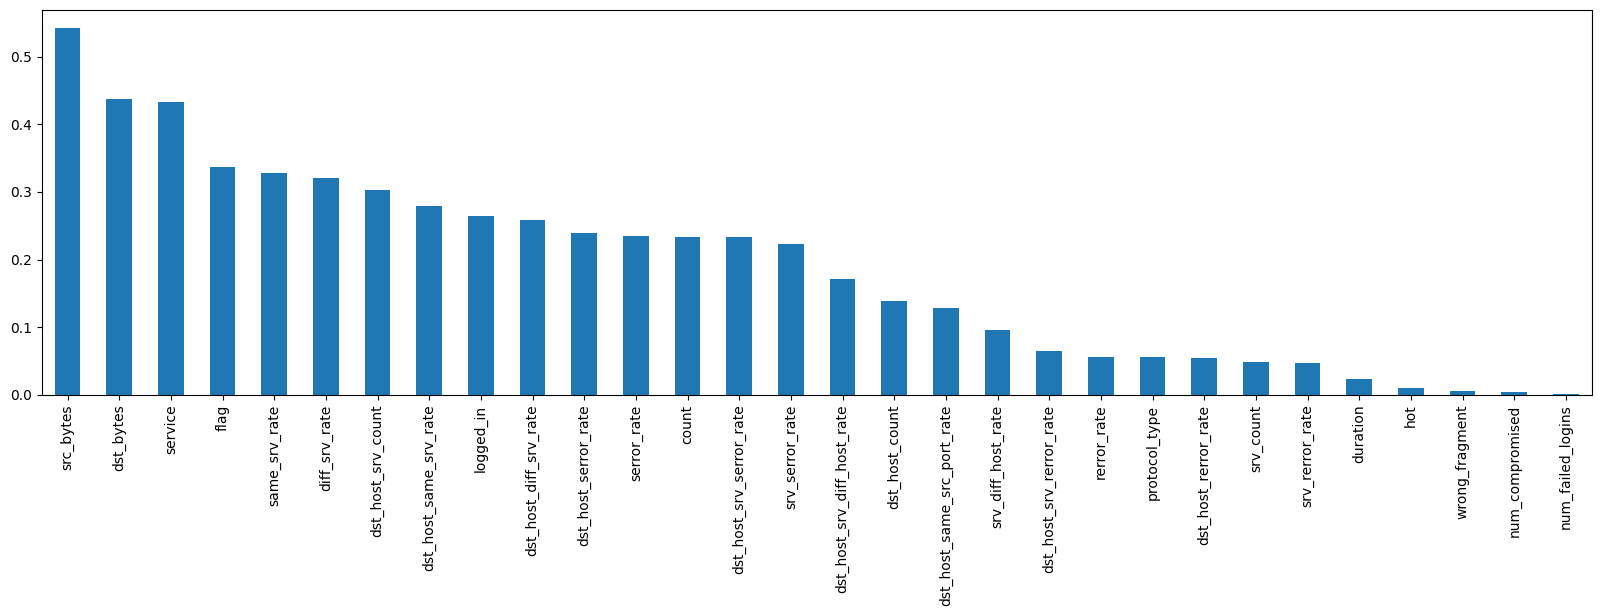

In [15]:
mi_scores.sort_values(ascending=False).plot.bar(figsize=(20, 5));

In [17]:
# Display the selected features
print("Selected Features after Mutual Information Filtering:")
print(final_selected_features.tolist())
print(f"\nNumber of Columns Retained: {len(final_selected_features)}")

Selected Features after Mutual Information Filtering:
['protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'logged_in', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

Number of Columns Retained: 24


In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(50),
    Dropout(0.3),
    Dense(2, activation='softmax')  # Change from 1 neuron (sigmoid) to 2 neurons (softmax)
])

# Compile the model with categorical loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train Model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

In [ ]:
# Plot Training Loss & Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.title("LSTM Model Training Performance")
plt.show()

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Convert y_test back to labels
y_test_labels = np.argmax(y_test, axis=1)

In [ ]:
# Convert one-hot encoded labels to single-class labels
y_test_labels = np.argmax(y_test, axis=1)  # Convert test labels to class index
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert predictions to class index

# Now use classification metrics
print("Confusion Matrix:\n", confusion_matrix(y_test_labels, y_pred_labels))
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))


In [18]:
# Standardize Data
scaler = StandardScaler()
X_final = scaler.fit_transform(X_final)

In [19]:
from sklearn.model_selection import StratifiedKFold
# K-Fold Cross Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_accuracies = []

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1s = []

X_final_np = X_final

In [21]:
for fold, (train_index, test_index) in enumerate(kf.split(X_final_np, y), 1):
    X_train, X_test = X_final_np[train_index], X_final_np[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    if len(np.unique(y_train)) < 2:
        print(f"Skipping Fold {fold} (Only one class in training data)")
        continue

    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)  # Avoid division by zero
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    fold_accuracies.append(acc)
    fold_precisions.append(prec)
    fold_recalls.append(rec)
    fold_f1s.append(f1)

    print(f"Fold {fold}:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 50)


Fold 1:
Confusion Matrix:
[[7371  335]
 [ 735 6411]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      7706
           1       0.95      0.90      0.92      7146

    accuracy                           0.93     14852
   macro avg       0.93      0.93      0.93     14852
weighted avg       0.93      0.93      0.93     14852

--------------------------------------------------
Fold 2:
Confusion Matrix:
[[7370  336]
 [ 768 6378]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      7706
           1       0.95      0.89      0.92      7146

    accuracy                           0.93     14852
   macro avg       0.93      0.92      0.93     14852
weighted avg       0.93      0.93      0.93     14852

--------------------------------------------------
Fold 3:
Confusion Matrix:
[[7363  343]
 [ 714 6432]]
Classification Report:
              pr

Average Accuracy: 0.9269
Average Precision: 0.9503
Average Recall: 0.8949
Average F1-score: 0.9218


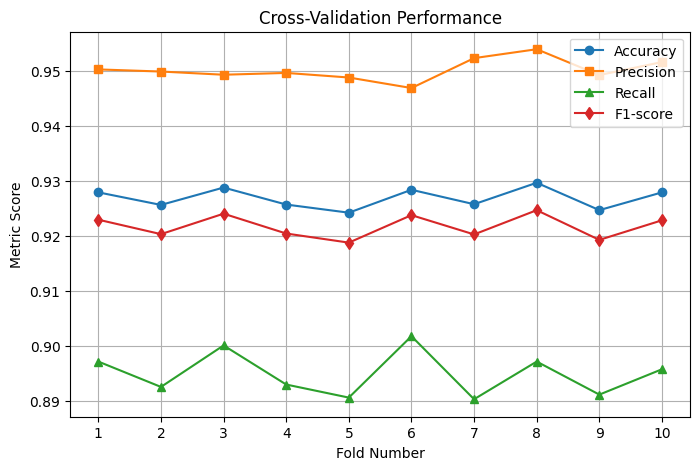

In [23]:
if fold_accuracies:
    avg_acc = np.mean(fold_accuracies)
    avg_prec = np.mean(fold_precisions)
    avg_rec = np.mean(fold_recalls)
    avg_f1 = np.mean(fold_f1s)

    print(f"Average Accuracy: {avg_acc:.4f}")
    print(f"Average Precision: {avg_prec:.4f}")
    print(f"Average Recall: {avg_rec:.4f}")
    print(f"Average F1-score: {avg_f1:.4f}")

    #Plot performance across folds
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(fold_accuracies) + 1), fold_accuracies, marker='o', label='Accuracy')
    plt.plot(range(1, len(fold_precisions) + 1), fold_precisions, marker='s', label='Precision')
    plt.plot(range(1, len(fold_recalls) + 1), fold_recalls, marker='^', label='Recall')
    plt.plot(range(1, len(fold_f1s) + 1), fold_f1s, marker='d', label='F1-score')

    plt.xticks(range(1, len(fold_accuracies) + 1))
    plt.xlabel('Fold Number')
    plt.ylabel('Metric Score')
    plt.title('Cross-Validation Performance')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("No valid folds with both classes. Check dataset balance.")

In [25]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, val_scores = learning_curve(
    model, X_final, y, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

print("Training Scores (Mean):", train_mean)
print("Validation Scores (Mean):", val_mean)


Training Scores (Mean): [0.947193   0.94704149 0.94652526 0.94755071 0.94650035 0.94620618
 0.94564496 0.94621301 0.93309268 0.92847524]
Validation Scores (Mean): [0.91936168 0.91872875 0.91868161 0.91910581 0.91845941 0.91823722
 0.91779955 0.91792748 0.91695788 0.91584015]


In [26]:
import pandas as pd
scores_df = pd.DataFrame({
    "Train Size": train_sizes,
    "Training Score": train_mean,
    "Validation Score": val_mean
})
print(scores_df)

   Train Size  Training Score  Validation Score
0       11881        0.947193          0.919362
1       23762        0.947041          0.918729
2       35643        0.946525          0.918682
3       47524        0.947551          0.919106
4       59406        0.946500          0.918459
5       71287        0.946206          0.918237
6       83168        0.945645          0.917800
7       95049        0.946213          0.917927
8      106930        0.933093          0.916958
9      118812        0.928475          0.915840


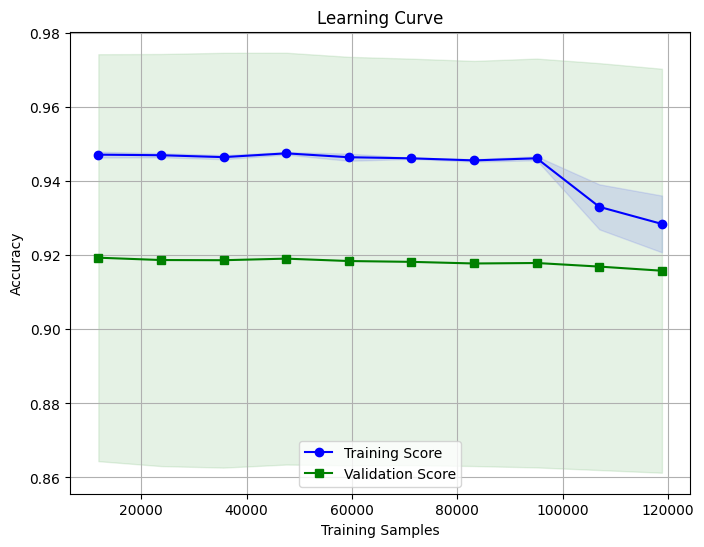

In [27]:
# Plot Learning Curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training Score", color="blue")
plt.plot(train_sizes, val_mean, 's-', label="Validation Score", color="green")

# Fill between to show standard deviation
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="green")

plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()

# Domain Adaptation Techniques

## 1. Introduction to Domain Adaptation
Domain adaptation is a technique used to improve model performance when training and test data come from different distributions. Key approaches include Transfer Learning and Adversarially Robust Intrusion Detection.

## 2. Transfer Learning for Domain Adaptation
Transfer learning leverages knowledge from a pre-trained model to adapt to a new task with limited data.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

## 3. Adversarially Robust Intrusion Detection
Adversarial training enhances model robustness against adversarial attacks in cybersecurity applications.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Generate synthetic adversarial data
x_train = np.random.rand(1000, 20)
y_train = np.random.randint(2, size=(1000, 1))

# Define a simple neural network
model = Sequential([
    Dense(64, activation='relu', input_shape=(20,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=32)

## 4. Accuracy Analysis
Performance evaluation using Precision, Recall, F1-score, and Confusion Matrix.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Generate synthetic test data
x_test = np.random.rand(200, 20)
y_test = np.random.randint(2, size=(200, 1))
y_pred = (model.predict(x_test) > 0.5).astype(int)

# Compute accuracy metrics
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))